In [2]:
# This line is a convenience to import most packages you'll need. You may need to import others (eg random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

/Users/sam/miniconda2/envs/eecs352/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [35]:
from scipy.fftpack import fft
from scipy.signal import hann

def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = 1 + length_to_cover_with_hops/hop_size;
    
    # make our window function
    if (window_type == 'hann'):
        window = sp.signal.hann(window_size, sym=False)
    else:
        window = np.ones(window_size)
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft).T

In [36]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i] 
    is the FFT of the ith window as input and stft[i,k] is the kth frequency of analysis.
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    
    # make an empty signal of the appropriate length
    window_size,num_hops = X.shape
    signal_length = (num_hops-1)*hop_size + window_size 
    signal = np.zeros(signal_length,dtype='complex');
    
    #fill the signal
    for n in range(num_hops):
        start = n * hop_size
        end = start + window_size
        signal[start:end] = signal[start:end] + ifft(X[:,n])
    return signal

In [33]:
def plt_spectrogram(X,win_length, hop_size, sample_rate, zoom_x=None, zoom_y=None,tick_labels='time-freq'):
    """
    Plots the log magnitude spectrogram.
    
    Input Parameters:
    ------------------
    X: 2D complex numpy array containing the stft values. Rows correspond to frequency bins and columns to time frames.
    win_length: the length of the analysis window
    hop_size: the hop size between adjacent windows
    sample_rate: sampling frequency
    tick_labels: the type of x and y tick labels, there are two options:
                 'time-freq': shows times (sec) on the x-axis and frequency (Hz) on the y-axis (default)
                 'bin-frame': shows time frame number on the x-axis and frequency bin number on the y-axis
                
    zoom_x: 1 by 2 numpy array containing the range of values on the x-axis, e.g. zoom_t=np.array([x_start,x_end])
    zoom_y: 1 by 2 numpy array containing the range of values on the y-axis, e.g. zoom_f=np.array([y_start,y_end])
    
    
    Returns:
    ---------
    times: 1D real numpy array containing time instances corresponding to stft frames
    freqs: 1D real numpy array containing frequencies of analyasis up to Nyquist rate
    2D plot of the magnitude spectrogram
    """
    
    # Find the size of stft
    Nf,Nt=np.shape(X)
    
    # Compute the log magnitude spectrogram
    X=20*np.log10(np.abs(X))
    
    # Extract the first half of the spectrum for each time frame
    X=X[0:Nf/2]
    Nf=np.shape(X)[0]
        
    # Generate time vector for plotting
    times=(hop_size/float(sample_rate))*np.arange(Nt)
    
    # Generate frequency vector for plotting
    freqs=(float(sample_rate)/win_length)*np.arange(Nf)
    
    # Generate time and frequency matrices for pcolormesh
    times_matrix,freqs_matrix=np.meshgrid(times,freqs)
    
    # Plot the log magnitude spectrogram
    plt.title('Log magnitude spectrogram')
    if tick_labels == 'bin-frame':
        plt.pcolormesh(X)
        plt.xlabel('Time-frame Number')
        plt.ylabel('Frequency-bin Number')
    else:
        plt.pcolormesh(times_matrix,freqs_matrix,X)
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')

    # Zoom in on the plot if specified
    if zoom_x is None and zoom_y is None:
        plt.axis('tight')
        
    if zoom_x is not None:
        plt.xlim(zoom_x)
        
    if zoom_y is not None:
        plt.ylim(zoom_y)
        
    return X

In [5]:
from scipy import signal
from scipy import fftpack
from time import time
time1 = time()
from librosa import load
import matplotlib.pyplot as plt
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

In [73]:
window_size = 2048
hop_size = 1024

beethovenrecord, sr = load('beetrecord10secsCLIPPED.wav')
beethovenrecord_voice, sr = load('beetrecord10secsVoice.wav')
beethovenrecord_live, sr = load('beetrecord10secsLiveCLIPPED.wav')
beethovenrecord_livevoice, sr = load('beetrecord10secsLiveCLIPPEDNEWVOICE.wav')
beethovenrecord_livevoice_segment = beethovenrecord_livevoice[len(beethovenrecord_livevoice)*3/10:len(beethovenrecord_livevoice)*5/10]

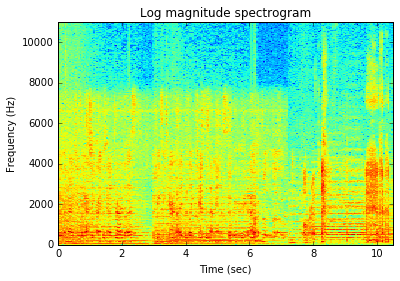

In [62]:
X = stft(beethovenrecord, window_size, hop_size)
V = plt_spectrogram(X, window_size, hop_size, sr)

X_voice = stft(beethovenrecord_voice, window_size, hop_size)
V_voice = plt_spectrogram(X_voice, window_size, hop_size, sr)

X_live = stft(beethovenrecord_live, window_size, hop_size)
V_live = plt_spectrogram(X_live, window_size, hop_size, sr)

X_livevoice = stft(beethovenrecord_livevoice, window_size, hop_size)
V_livevoice = plt_spectrogram(X_livevoice, window_size, hop_size, sr)

In [89]:
Audio(beethovenrecord[:156*hop_size], rate=sr)

In [86]:
Audio(beethovenrecord_live, rate=sr)

array([[ -8.73594079, -26.02372072,  -7.95342167, ...,  -0.70373735,
         -8.23785619,  -0.51110721],
       [ -5.2642325 ,  -8.33758041, -11.31266292, ...,  -1.98149942,
         -9.36711651,  -1.96237869],
       [ -4.75153416,  -4.22982185,  -9.85400791, ..., -10.58317615,
         -9.6401467 ,  -5.69598859],
       ..., 
       [-16.02635202, -29.32328933, -19.82691025, ..., -47.99340676,
        -63.47594801, -55.49893696],
       [-14.60914354, -21.55777855, -23.11414707, ..., -52.07361837,
        -58.0323568 , -51.07523012],
       [-15.19079598, -29.0128234 , -36.00798809, ..., -40.74144537,
        -38.77188287, -38.58037711]])

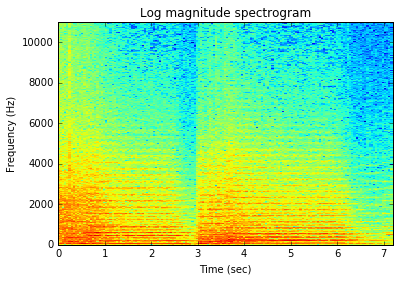

In [110]:
plt_spectrogram(X_live, window_size, hop_size, sr)

array([[-11.76633364, -14.00330813, -48.04738709, ..., -35.67846865,
        -25.97509743, -27.93205513],
       [-15.1981363 , -12.24753657, -25.90539637, ..., -28.56895214,
        -30.14565994, -25.8466715 ],
       [-22.90816202, -16.96229608, -27.87551389, ..., -27.09778121,
        -29.37876599, -24.12496983],
       ..., 
       [-50.59289104, -38.78748257, -49.3136948 , ..., -54.46712618,
        -49.9282551 , -54.54470101],
       [-46.98107626, -41.14452908, -52.85647607, ..., -53.96161121,
        -59.55029822, -65.72664073],
       [-47.10491997, -48.26163804, -46.6932735 , ..., -50.76113084,
        -66.94001099, -62.16579781]])

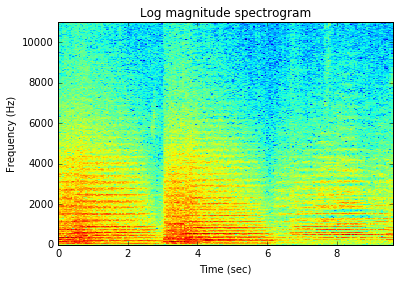

In [111]:
plt_spectrogram(X, window_size, hop_size, sr)

array([[ -9.5145735 , -28.52744488,  -7.55249433, ...,  -0.83612573,
         -8.29865165,  -0.52002207],
       [ -5.73414747,  -9.51409545,  -9.31513646, ...,  -2.14464389,
         -9.42915651,  -1.96839127],
       [ -5.18304391,  -4.81341488, -10.61103678, ..., -10.76481714,
         -9.71715856,  -5.67350846],
       ..., 
       [-16.12569955, -29.30593557, -19.88906182, ..., -46.87655272,
        -52.48855218, -59.66857027],
       [-14.67906369, -21.69374626, -23.29183901, ..., -49.84782742,
        -52.94846096, -52.6274471 ],
       [-15.14470521, -28.70325561, -36.04523555, ..., -40.21885829,
        -37.32169902, -38.4571224 ]])

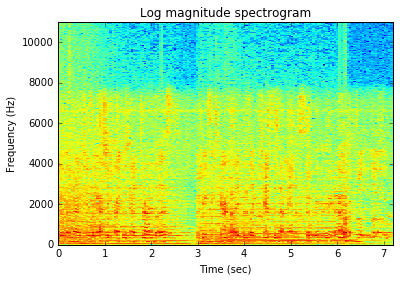

In [112]:
plt_spectrogram(X_livevoice, window_size, hop_size, sr)

In [ ]:
def getridofthemvocalsyo(segment, V):
    V_norm = (V - np.min(V)) / (np.max(V) - np.min(V))
    V_norm = V_norm[:,:156]

    V_live_norm = (V_live - np.min(V_live)) / (np.max(V_live) - np.min(V_live))

    V_livevoice_norm = (V_livevoice - np.min(V_livevoice)) / (np.max(V_livevoice) - np.min(V_livevoice))

    V_diff = V_livevoice - V_live

    V_diff_norm = (V_diff - np.min(V_diff)) / (np.max(V_diff) - np.min(V_diff))

    # this should always be between 1 and -1 (but probably 0 and 1)
    thresh = 0.1
    thrscount = 0
    ltanzeroct = 0
    M_bottomhalf = np.ones((V_diff.shape[0], V_diff.shape[1]))
    for i in range(V_diff.shape[0]):
        for j in range(V_diff.shape[1]):
    #         if it's louder than the thresh, assume that it's vocals and mask it out
            if V_diff[i, j] > thresh:
                thrscount += 1
                M_bottomhalf[i, j] = 0
            if V_diff[i, j] < 0:
                ltanzeroct += 1

    print "ltzer", ltanzeroct    
    print "size", M_bottomhalf.shape[0] * M_bottomhalf.shape[1]
    print thrscount / float(M_bottomhalf.shape[0] * M_bottomhalf.shape[1] )

    M = np.zeros((V_diff.shape[0] * 2, V_diff.shape[1]))
    M[:V_diff.shape[0], :] = M_bottomhalf
    M[V_diff.shape[0]:, :] = np.flipud(M_bottomhalf)
    print M

    filtered = X_livevoice * M

    newsignal = istft(filtered, hop_size)
    Audio(newsignal, rate=sr)

In [126]:
V_norm = (V - np.min(V)) / (np.max(V) - np.min(V))
V_norm = V_norm[:,:156]

V_live_norm = (V_live - np.min(V_live)) / (np.max(V_live) - np.min(V_live))

V_livevoice_norm = (V_livevoice - np.min(V_livevoice)) / (np.max(V_livevoice) - np.min(V_livevoice))

V_diff = V_livevoice - V_live

V_diff_norm = (V_diff - np.min(V_diff)) / (np.max(V_diff) - np.min(V_diff))

# this should always be between 1 and -1 (but probably 0 and 1)
thresh = .5
thrscount = 0
ltanzeroct = 0
M_bottomhalf = np.ones((V_diff.shape[0], V_diff.shape[1]))
for i in range(V_diff.shape[0]):
    for j in range(V_diff.shape[1]):
#         if it's louder than the thresh, assume that it's vocals and mask it out
        if V_diff_norm[i, j] > thresh:
            thrscount += 1
            M_bottomhalf[i, j] = 0
        if V_diff_norm[i, j] < 0:
            ltanzeroct += 1
            
print "ltzer", ltanzeroct 
print "threshct", thrscount
print "size", M_bottomhalf.shape[0] * M_bottomhalf.shape[1]
print thrscount / float(M_bottomhalf.shape[0] * M_bottomhalf.shape[1] )

M = np.zeros((V_diff.shape[0] * 2, V_diff.shape[1]))
M[:V_diff.shape[0], :] = M_bottomhalf
M[V_diff.shape[0]:, :] = np.flipud(M_bottomhalf)
print M

filtered = X_livevoice * M

newsignal = istft(filtered, hop_size)
Audio(newsignal, rate=sr)

ltzer 0
threshct 48591
size 159744
0.304180438702
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


In [74]:
Audio(beethovenrecord_livevoice_segment, rate=sr)
# play the segment to see if it seems long enough

In [97]:
# index for now seems to be finding where in the original recording the livevoice_segment is

autocorr = sp.signal.correlate(beethovenrecord, beethovenrecord_livevoice_segment, mode='valid')
print np.max(autocorr)

for i in range(0, len(autocorr)):
    if autocorr[i] == np.max(autocorr):
        timeindexinoriginal = i
specstartinoriginal = timeindexinoriginal/hop_size
specendinoriginal = specstartinoriginal + len(beethovenrecord_livevoice_segment)/hop_size
print timeindexinoriginal

16.9696
52172


In [105]:
Audio(beethovenrecord_live[timeindexinoriginal:timeindexinoriginal+len(beethovenrecord_livevoice_segment)], rate=sr)

In [109]:
print len(istft(X[:,specstartinoriginal:specendinoriginal], hop_size))
print len(beethovenrecord_livevoice_segment)
# Audio(, rate=sr)

32768
32329
